In [1]:
import os
os.environ['CUPY_ACCELERATORS'] = 'cutensor'
import numpy as np
import cupy as cp
from cupyx.scipy import fft as cupyx_fft
from scipy import misc, fft as scipy_fft
import zarr
from matplotlib import pyplot, colors, cm
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import display

In [2]:
cp.cuda.set_pinned_memory_allocator(None)
mempool = cp.get_default_memory_pool()

In [3]:
# Plot functions

colors.get_named_colors_mapping().update({
    'lfd:signal': "#4e79a7",
    'lfd:pupil': "#59a14f",
    'lfd:retina': "#e15759",
    'lfd:filter': "#f28e2b",
})



# Basic array functions

def sampling_lattice(res, pitch=1.0):
    """Return an array of shape (res,) containing the coordinates of a sampling lattice with a given pitch in "standard" order (with zero at the start)."""
    return scipy_fft.fftfreq(res).astype(np.float32) * (res * pitch)

def display_image(values, color_map=None, absolute=True, normalize=True, shift=False, flip=False):
    """Display an array as an image using a color map. The image can be normalized, shifted and/or flipped."""
    values = np.abs(values) if absolute else values
    values = values * np.nan_to_num(1.0 / np.amax(values)) if normalize else values
    values = scipy_fft.fftshift(values) if shift else values
    values = np.flip(values) if flip else values
    color_values = cm.get_cmap(color_map)(values, bytes=True)
    display(Image.fromarray(color_values).transpose(Image.ROTATE_90))



# Spatial and spectral transformations between the display and the eye spaces

def x_ab_to_r(x_a, x_b, z_r, z_a, z_b, z_f):
    """Return the position on the retina from the positions on the display layers."""
    return (1 - z_b/z_f) * z_r/(z_a - z_b) * x_a + (1 - z_a/z_f) * z_r/(z_b - z_a) * x_b

def x_ab_to_p(x_a, x_b, z_a, z_b):
    """Return the position on the pupil from the positions on the display layers."""
    return z_b/(z_b - z_a) * x_a + z_a/(z_a - z_b) * x_b

def x_rp_to_a(x_r, x_p, z_r, z_a, z_f):
    """Return the position on the display layer A from the positions on the retina and pupil."""
    return (z_a/z_r) * x_r + (1 - z_a/z_f) * x_p

def x_rp_to_b(x_r, x_p, z_r, z_b, z_f):
    """Return the position on the display layer B from the positions on the retina and pupil."""
    return (z_b/z_r) * x_r + (1 - z_b/z_f) * x_p

def xi_ab_to_r(xi_a, xi_b, z_r, z_a, z_b):
    """Return the frequency on the retina from the frequencies on the display layers."""
    return (z_a/z_r) * xi_a + (z_b/z_r) * xi_b

def xi_ab_to_p(xi_a, xi_b, z_a, z_b, z_f):
    """Return the frequency on the pupil from the frequencies on the display layers."""
    return (1 - z_a/z_f) * xi_a + (1 - z_b/z_f) * xi_b

def xi_rp_to_a(xi_r, xi_p, z_r, z_a, z_b, z_f):
    """Return the frequency on the display layer A from the frequencies on the retina and pupil."""
    return (1 - z_b/z_f) * z_r/(z_a - z_b) * xi_r + z_b/(z_b - z_a) * xi_p

def xi_rp_to_b(xi_r, xi_p, z_r, z_a, z_b, z_f):
    """Return the frequency on the display layer B from the frequencies on the retina and pupil."""
    return (1 - z_a/z_f) * z_r/(z_b - z_a) * xi_r + z_a/(z_a - z_b) * xi_p



# Circle functions

def semicircle(x):
    """Return the positive y coordinate associated to an x coordinate in a unit circle."""
    return cp.sqrt(1.0 - cp.square(x))

def semicircle_integral(x):
    """Return the indefinite integral at x of the semicircle function."""
    return (cp.sqrt(1.0 - cp.square(x)) * x + cp.arcsin(x))/2

def circle_box_area(x_interval, y_interval):
    """Return the area of the intersection of a box against the unit circle."""
    # Positive semicircle medial
    y_clipped = cp.clip(y_interval[..., 0], 0, 1)
    circle_edge = semicircle(y_clipped)
    x_clipped = cp.clip(x_interval[..., 0], -circle_edge, circle_edge)
    area = x_clipped * y_clipped - semicircle_integral(x_clipped)
    x_clipped = cp.clip(x_interval[..., 1], -circle_edge, circle_edge)
    area -= x_clipped * y_clipped - semicircle_integral(x_clipped)

    # Positive semicircle lateral
    y_clipped = cp.clip(y_interval[..., 1], 0, 1)
    circle_edge = semicircle(y_clipped)
    x_clipped = cp.clip(x_interval[..., 0], -circle_edge, circle_edge)
    area -= x_clipped * y_clipped - semicircle_integral(x_clipped)
    x_clipped = cp.clip(x_interval[..., 1], -circle_edge, circle_edge)
    area += x_clipped * y_clipped - semicircle_integral(x_clipped)

    # Negative semicircle medial
    y_clipped = cp.clip(-y_interval[..., 1], 0, 1)
    circle_edge = semicircle(y_clipped)
    x_clipped = cp.clip(x_interval[..., 0], -circle_edge, circle_edge)
    area += x_clipped * y_clipped - semicircle_integral(x_clipped)
    x_clipped = cp.clip(x_interval[..., 1], -circle_edge, circle_edge)
    area -= x_clipped * y_clipped - semicircle_integral(x_clipped)

    # Negative semicircle lateral
    y_clipped = cp.clip(-y_interval[..., 0], 0, 1)
    circle_edge = semicircle(y_clipped)
    x_clipped = cp.clip(x_interval[..., 0], -circle_edge, circle_edge)
    area -= x_clipped * y_clipped - semicircle_integral(x_clipped)
    x_clipped = cp.clip(x_interval[..., 1], -circle_edge, circle_edge)
    area += x_clipped * y_clipped - semicircle_integral(x_clipped)

    return area



# 2d signals defined in [0, 1]²

def constant_signal(x, y):
    return cp.broadcast_arrays(1.0, x, y)[0].astype(cp.float32)

def cosine_signal(x, y):
    max_frequency = 375/8
    frequency = y * (max_frequency * 2 * np.pi)
    coord = x - 0.5
    return ((cp.cos(coord * frequency) + 1) * 0.5)

def image_signal(x, y, image):
    idx_x = cp.clip(cp.floor(x * image.shape[0]), 0, image.shape[0]-1).astype(cp.int32).get()
    idx_y = cp.clip(cp.floor(y * image.shape[1]), 0, image.shape[1]-1).astype(cp.int32).get()
    return image[idx_x, idx_y]

def raccon_signal(x, y):
    raccoon = cp.array(misc.face(True).T[-769:-1, ::-1]).astype(cp.float32)
    return image_signal(x, y, raccoon)



# Sampling functions

def sample_signal_quadrants(signal_out, signal_function, res_a, res_b, size_r, size_a, size_b, z_r, z_a, z_b, z_f, block_size=1):
    # Compute display coordinates
    x_a = sampling_lattice(res_a, size_a / res_a)[np.newaxis, :, np.newaxis]
    x_b = sampling_lattice(res_b, size_b / res_b)[np.newaxis, np.newaxis, :]
    z_f = np.array(z_f, dtype=np.float32)[:, np.newaxis, np.newaxis]
    # Project display samples to the retina plane for each z_f
    x_r_over_fab = x_ab_to_r(x_a, x_b, z_r, z_a, z_b, z_f) * (2 / size_r)
    # Translate to the first quadrant
    y_r_over_fab = (x_r_over_fab + np.array([0.0, 0.0, 1.0, 1.0], dtype=np.float32)[:, np.newaxis, np.newaxis])
    x_r_over_fab = (x_r_over_fab + np.array([0.0, 1.0, 1.0, 0.0], dtype=np.float32)[:, np.newaxis, np.newaxis])
    # Move to GPU
    x_r_over_fab = cp.array(x_r_over_fab)
    y_r_over_fab = cp.array(y_r_over_fab)
    # Serialize the computation over the first array dimension
    for block_start in tqdm(np.arange(0, res_a, step=block_size, dtype=np.uint32), desc='Sampling'):
        block_slice = slice(block_start, np.minimum(block_start + block_size, res_a))
        # Initialize the signal and the occlusion mask slices
        signal_sabb = cp.zeros((block_size, res_a, res_b, res_b), dtype=cp.float32)
        unoccluded_sabb = cp.full((block_size, res_a, res_b, res_b), True)
        for idx_z in range(4):
            x_sabb, y_sabb = cp.broadcast_arrays(x_r_over_fab[idx_z, block_slice, np.newaxis, :, np.newaxis], y_r_over_fab[idx_z, np.newaxis, :, np.newaxis, :])

            mask_sabb = unoccluded_sabb.copy()
            cp.logical_and(mask_sabb, x_sabb >= 0.0, out=mask_sabb)
            cp.logical_and(mask_sabb, x_sabb < 1.0, out=mask_sabb)
            cp.logical_and(mask_sabb, y_sabb >= 0.0, out=mask_sabb)
            cp.logical_and(mask_sabb, y_sabb < 1.0, out=mask_sabb)

            signal_sabb[mask_sabb] = signal_function(x_sabb[mask_sabb], y_sabb[mask_sabb])

            cp.logical_not(mask_sabb, out=mask_sabb)
            cp.logical_and(unoccluded_sabb, mask_sabb, out=unoccluded_sabb)
        # Store the signal slice
        signal_out[block_slice] = signal_sabb.get()
    return signal_out

def sample_eye_function(signal_out, res_a, res_b, size_a, size_b, z_r, z_a, z_b, z_f, w_r, w_p, block_size=1):
    # Compute display coordinates
    x_a = sampling_lattice(res_a, size_a / res_a)[:, np.newaxis]
    x_b = sampling_lattice(res_b, size_b / res_b)[np.newaxis, :]
    # Project display samples to the retina and pupil planes
    x_r_over_ab = x_ab_to_r(x_a, x_b, z_r, z_a, z_b, z_f)
    x_p_over_ab = x_ab_to_p(x_a, x_b, z_a, z_b)
    # Move to GPU
    x_r_over_ab = cp.array(x_r_over_ab)
    x_p_over_ab = cp.array(x_p_over_ab)
    # Serialize the computation over the first array dimension
    for block_start in tqdm(np.arange(0, res_a, step=block_size, dtype=np.uint32), desc='Sampling'):
        block_slice = slice(block_start, np.minimum(block_start + block_size, res_a))
        # Compute 4-dim coordinates from 2-dim coordinates
        x_r_over_sabb, y_r_over_sabb = cp.broadcast_arrays(x_r_over_ab[block_slice, np.newaxis, :, np.newaxis], x_r_over_ab[np.newaxis, :, np.newaxis, :])
        x_p_over_sabb, y_p_over_sabb = cp.broadcast_arrays(x_p_over_ab[block_slice, np.newaxis, :, np.newaxis], x_p_over_ab[np.newaxis, :, np.newaxis, :])
        # Compute eye function
        signal_sabb = cp.full((block_size, res_a, res_b, res_b), True)
        cp.logical_and(signal_sabb, cp.abs(x_r_over_sabb) <= w_r/2, out=signal_sabb)
        cp.logical_and(signal_sabb, cp.abs(y_r_over_sabb) <= w_r/2, out=signal_sabb)
        cp.logical_and(signal_sabb, cp.abs(x_p_over_sabb) <= w_p/2, out=signal_sabb)
        cp.logical_and(signal_sabb, cp.abs(y_p_over_sabb) <= w_p/2, out=signal_sabb)
        # Store the signal slice
        signal_out[block_slice] = signal_sabb.get()

def decimate_signal(signal_in, signal_out, factor):
    for idx_a in tqdm(np.arange(0, signal_out.shape[0], dtype=np.uint32), desc='Decimating'):
        signal_out[idx_a] = signal_in[idx_a * factor, ::factor, ::factor, ::factor]



# Fourier transform

def abs_fft4(signal_in, spectrum_out, block_size=1):
    """Computes the absolute value of the Fast Fourier Transform of a 4-dimensional signal."""
    semispectrum = zarr.open('data/semispectrum.zarr', mode='w', shape=spectrum_out.shape, chunks=spectrum_out.chunks, dtype=np.complex64)

    for block_start in tqdm(np.arange(0, signal_in.shape[0], step=block_size, dtype=np.uint32), desc='FFT2 axes=(1, 3)'):
        block_slice = slice(block_start, np.minimum(block_start + block_size, signal_in.shape[0]))
        semispectrum[block_slice] = cupyx_fft.fft2(cp.array(signal_in[block_slice]).astype(cp.complex64), axes=(1, 3)).get()
    cp.fft.config.get_plan_cache().clear()

    for block_start in tqdm(np.arange(0, signal_in.shape[1], step=block_size, dtype=np.uint32), desc='FFT2 axes=(0, 2)'):
        block_slice = slice(block_start, np.minimum(block_start + block_size, signal_in.shape[1]))
        spectrum_out[:, block_slice] = cp.abs(cupyx_fft.fft2(cp.array(semispectrum[:, block_slice]), axes=(0, 2))).get()
    cp.fft.config.get_plan_cache().clear()

def fft4(signal_in, spectrum_out, block_size=1):
    """Computes the Fast Fourier Transform of a 4-dimensional signal."""
    semispectrum = zarr.open('data/semispectrum.zarr', mode='w', shape=spectrum_out.shape, chunks=spectrum_out.chunks, dtype=np.complex64)

    for block_start in tqdm(np.arange(0, signal_in.shape[0], step=block_size, dtype=np.uint32), desc='FFT2 axes=(1, 3)'):
        block_slice = slice(block_start, np.minimum(block_start + block_size, signal_in.shape[0]))
        semispectrum[block_slice] = cupyx_fft.fft2(cp.array(signal_in[block_slice]).astype(cp.complex64), axes=(1, 3)).get()
    cp.fft.config.get_plan_cache().clear()

    for block_start in tqdm(np.arange(0, signal_in.shape[1], step=block_size, dtype=np.uint32), desc='FFT2 axes=(0, 2)'):
        block_slice = slice(block_start, np.minimum(block_start + block_size, signal_in.shape[1]))
        spectrum_out[:, block_slice] = cupyx_fft.fft2(cp.array(semispectrum[:, block_slice]), axes=(0, 2)).get()
    cp.fft.config.get_plan_cache().clear()

def ifft4(spectrum_in, signal_out, block_size=1):
    """Computes the inverse Fast Fourier Transform of a 4-dimensional spectrum."""
    semispectrum = zarr.open('data/semispectrum.zarr', mode='w', shape=spectrum_in.shape, chunks=spectrum_in.chunks, dtype=np.complex64)

    for block_start in tqdm(np.arange(0, signal_out.shape[1], step=block_size, dtype=np.uint32), desc='IFFT2 axes=(0, 2)'):
        block_slice = slice(block_start, np.minimum(block_start + block_size, signal_out.shape[1]))
        semispectrum[:, block_slice] = cupyx_fft.ifft2(cp.array(spectrum_in[:, block_slice]), axes=(0, 2)).get()
    cp.fft.config.get_plan_cache().clear()

    for block_start in tqdm(np.arange(0, signal_out.shape[0], step=block_size, dtype=np.uint32), desc='IFFT2 axes=(1, 3)'):
        block_slice = slice(block_start, np.minimum(block_start + block_size, signal_out.shape[0]))
        signal_out[block_slice] = cupyx_fft.ifft2(cp.array(semispectrum[block_slice]), axes=(1, 3)).get()
    cp.fft.config.get_plan_cache().clear()

def rfft4(signal_in, spectrum_out, block_size=1):
    """Computes the real Fast Fourier Transform of a 4-dimensional signal."""
    semispectrum = zarr.open('data/semispectrum.zarr', mode='w', shape=spectrum_out.shape, chunks=spectrum_out.chunks, dtype=np.complex64)

    for block_start in tqdm(np.arange(0, signal_in.shape[0], step=block_size, dtype=np.uint32), desc='RFFT2 axes=(1, 3)'):
        block_slice = slice(block_start, np.minimum(block_start + block_size, signal_in.shape[0]))
        semispectrum[block_slice] = cupyx_fft.rfft2(cp.array(signal_in[block_slice]).astype(cp.float32), axes=(1, 3)).get()
    cp.fft.config.get_plan_cache().clear()

    for block_start in tqdm(np.arange(0, signal_in.shape[1], step=block_size, dtype=np.uint32), desc='FFT2 axes=(0, 2)'):
        block_slice = slice(block_start, np.minimum(block_start + block_size, signal_in.shape[1]))
        spectrum_out[:, block_slice] = cupyx_fft.fft2(cp.array(semispectrum[:, block_slice]), axes=(0, 2)).get()
    cp.fft.config.get_plan_cache().clear()

def irfft4(spectrum_in, signal_out, block_size=1):
    """Computes the inverse real Fast Fourier Transform of a 4-dimensional spectrum."""
    semispectrum = zarr.open('data/semispectrum.zarr', mode='w', shape=spectrum_in.shape, chunks=spectrum_in.chunks, dtype=np.complex64)

    for block_start in tqdm(np.arange(0, signal_out.shape[1], step=block_size, dtype=np.uint32), desc='IFFT2 axes=(0, 2)'):
        block_slice = slice(block_start, np.minimum(block_start + block_size, signal_out.shape[1]))
        semispectrum[:, block_slice] = cupyx_fft.ifft2(cp.array(spectrum_in[:, block_slice]), axes=(0, 2)).get()
    cp.fft.config.get_plan_cache().clear()

    for block_start in tqdm(np.arange(0, signal_out.shape[0], step=block_size, dtype=np.uint32), desc='IRFFT2 axes=(1, 3)'):
        block_slice = slice(block_start, np.minimum(block_start + block_size, signal_out.shape[0]))
        signal_out[block_slice] = cupyx_fft.irfft2(cp.array(semispectrum[block_slice]), s=signal_out.shape[1::2], axes=(1, 3)).get()
    cp.fft.config.get_plan_cache().clear()



# Imaging functions

def square_aperture(x_interval, y_interval):
    x_interval = cp.clip(x_interval, -1, 1)
    y_interval = cp.clip(y_interval, -1, 1)
    return (x_interval[..., 1] - x_interval[..., 0]) * (y_interval[..., 1] - y_interval[..., 0])

def round_aperture(x_interval, y_interval):
    return circle_box_area(x_interval, y_interval)

def compute_imaging_tensor(imaging_tensor_out, res_r, res_a, res_b, size_r, size_a, size_b, z_r, z_a, z_b, z_f, w_a, w_b, pupil_diameter, aperture, block_size=1):
    """Compute the contributions of each display sample to each retina sample."""
    # Compute coordinates
    x_r = sampling_lattice(res_r, size_r / res_r)[:, np.newaxis, np.newaxis]
    x_a = sampling_lattice(res_a, size_a / res_a)[np.newaxis, :, np.newaxis]
    x_b = sampling_lattice(res_b, size_b / res_b)[np.newaxis, np.newaxis, :]
    # Project display samples to the pupil plane
    x_a_at_p = (x_a - x_r * (z_a/z_r)) * np.reciprocal(1.0 - z_a/z_f)
    x_b_at_p = (x_b - x_r * (z_b/z_r)) * np.reciprocal(1.0 - z_b/z_f)
    # Project display element sizes to the pupil plane
    w_a_at_p = np.abs(w_a * np.reciprocal(1.0 - z_a/z_f))
    w_b_at_p = np.abs(w_b * np.reciprocal(1.0 - z_b/z_f))
    # Compute lower and upper bounds of projected display elements
    lower_bounds = np.clip(x_a_at_p - w_a_at_p/2, x_b_at_p - w_b_at_p/2, x_b_at_p + w_b_at_p/2)
    upper_bounds = np.clip(x_a_at_p + w_a_at_p/2, x_b_at_p - w_b_at_p/2, x_b_at_p + w_b_at_p/2)
    # Stack array as [..., 2] where the last dimension is lower|upper bounds and scale to pupil
    pupil_intervals = np.stack((lower_bounds, upper_bounds), axis=-1) * 2 / pupil_diameter
    # Move to GPU
    pupil_intervals = cp.array(pupil_intervals)
    # For each retina sample...
    for idx_r, idy_r in tqdm(np.ndindex((res_r, res_r)), total=res_r**2, desc='For each retina sample'):
        for block_start in np.arange(0, res_a, step=block_size, dtype=np.uint32):
            block_slice = slice(block_start, np.minimum(block_start + block_size, res_a))
            x_intervals = pupil_intervals[idx_r, block_slice, np.newaxis, :, np.newaxis, :]
            y_intervals = pupil_intervals[idy_r, np.newaxis, :, np.newaxis, :, :]
            imaging_tensor_out[idx_r, idy_r, block_slice] = aperture(x_intervals, y_intervals).astype(cp.float16).get()

def compute_retinal_images(signals_aabb, res_r, res_a, res_b, size_r, size_a, size_b, z_r, z_a, z_b, z_f, w_a, w_b, pupil_diameter, aperture, block_size=1):
    """Compute multiple retinal images simultaneously."""
    # Compute coordinates
    x_r = sampling_lattice(res_r, size_r / res_r)[:, np.newaxis, np.newaxis]
    x_a = sampling_lattice(res_a, size_a / res_a)[np.newaxis, :, np.newaxis]
    x_b = sampling_lattice(res_b, size_b / res_b)[np.newaxis, np.newaxis, :]
    # Project display samples to the pupil plane
    x_a_at_p = (x_a - x_r * (z_a/z_r)) * np.reciprocal(1.0 - z_a/z_f)
    x_b_at_p = (x_b - x_r * (z_b/z_r)) * np.reciprocal(1.0 - z_b/z_f)
    # Project display element sizes to the pupil plane
    w_a_at_p = np.abs(w_a * np.reciprocal(1.0 - z_a/z_f))
    w_b_at_p = np.abs(w_b * np.reciprocal(1.0 - z_b/z_f))
    # Compute lower and upper bounds of projected display elements
    lower_bounds = np.clip(x_a_at_p - w_a_at_p/2, x_b_at_p - w_b_at_p/2, x_b_at_p + w_b_at_p/2)
    upper_bounds = np.clip(x_a_at_p + w_a_at_p/2, x_b_at_p - w_b_at_p/2, x_b_at_p + w_b_at_p/2)
    # Stack array as [..., 2] where the last dimension is lower|upper bounds and scale to pupil
    pupil_intervals = np.stack((lower_bounds, upper_bounds), axis=-1) * 2 / pupil_diameter
    # Move to GPU
    pupil_intervals = cp.array(pupil_intervals)
    signals_aabb = [cp.array(signal_aabb) for signal_aabb in signals_aabb]
    # Create output retinal images
    retinal_images = [cp.zeros((res_r, res_r), dtype=cp.float32) for signal_aabb in signals_aabb]
    # For each retina sample...
    for idx_r, idy_r in tqdm(np.ndindex((res_r, res_r)), total=res_r**2, desc='For each retina sample'):
        for block_start in np.arange(0, res_a, step=block_size, dtype=np.uint32):
            block_slice = slice(block_start, np.minimum(block_start + block_size, res_a))
            x_intervals = pupil_intervals[idx_r, block_slice, np.newaxis, :, np.newaxis, :]
            y_intervals = pupil_intervals[idy_r, np.newaxis, :, np.newaxis, :, :]
            imaging_tensor = aperture(x_intervals, y_intervals)
            for i in range(len(signals_aabb)):
                retinal_images[i][idx_r, idy_r] += cp.sum(imaging_tensor * signals_aabb[i][block_slice])
    # Move to CPU
    retinal_images = [retinal_image.get() for retinal_image in retinal_images]
    return retinal_images



# Filter functions

def filter_G(xi_a0, xi_a1, xi_b0, xi_b1, z_a, z_b, z_f, w_a, w_b, pupil_diameter):
    return cp.abs(cp.sinc(xi_a0 * w_a) * cp.sinc(xi_a1 * w_a) * cp.sinc(xi_b0 * w_b) * cp.sinc(xi_b1 * w_b))

def filter_Q(xi_a0, xi_a1, xi_b0, xi_b1, z_a, z_b, z_f, w_a, w_b, pupil_diameter):
    xi_p0 = xi_ab_to_p(xi_a0, xi_b0, z_a, z_b, z_f)
    xi_p1 = xi_ab_to_p(xi_a1, xi_b1, z_a, z_b, z_f)
    return cp.abs(cp.sinc(xi_p0 * pupil_diameter) * cp.sinc(xi_p1 * pupil_diameter))

def filter_GQ(xi_a0, xi_a1, xi_b0, xi_b1, z_a, z_b, z_f, w_a, w_b, pupil_diameter):
    g = filter_G(xi_a0, xi_a1, xi_b0, xi_b1, z_a, z_b, z_f, w_a, w_b, pupil_diameter)
    q = filter_Q(xi_a0, xi_a1, xi_b0, xi_b1, z_a, z_b, z_f, w_a, w_b, pupil_diameter)
    return g * q

def compute_weight_filter(filter_function, spectral_filter, res_a, res_b, size_a, size_b, z_a, z_b, z_f, w_a, w_b, pupil_diameter, block_size=1):
    # Compute coordinates
    xi_a = sampling_lattice(res_a, 1/size_a)
    xi_b = sampling_lattice(res_b, 1/size_b)
    # Move to GPU
    xi_a = cp.array(xi_a)
    xi_b = cp.array(xi_b)
    # Serialize the computation over the first array dimension
    for block_start in tqdm(np.arange(0, res_a, step=block_size, dtype=np.uint32), desc='Computing filter'):
        block_slice = slice(block_start, np.minimum(block_start + block_size, res_a))
        xi_a0 = xi_a[block_slice, np.newaxis, np.newaxis, np.newaxis]
        xi_a1 = xi_a[np.newaxis, :, np.newaxis, np.newaxis]
        xi_b0 = xi_b[np.newaxis, np.newaxis, :, np.newaxis]
        xi_b1 = xi_b[np.newaxis, np.newaxis, np.newaxis, :]
        spectral_filter[block_slice] = filter_function(xi_a0, xi_a1, xi_b0, xi_b1, z_a, z_b, z_f, w_a, w_b, pupil_diameter).get()

def compute_choice_filter(weight_filter, choice_filter, factor):
    for block_start in tqdm(np.arange(0, weight_filter.shape[0]//factor, dtype=np.uint32), desc='Computing choice'):
        block_shape = (factor, weight_filter.shape[1], weight_filter.shape[2], weight_filter.shape[3])
        chosen_shape = (1, weight_filter.shape[1]//factor, weight_filter.shape[2]//factor, weight_filter.shape[3]//factor)
        # Initialize weight block
        weight_block = np.empty(block_shape, dtype=np.float32)
        for i in range(factor):
            weight_block[i] = weight_filter[block_start + i * weight_filter.shape[0]//factor]
        # Initialize choice block
        choice_block = np.full(block_shape, False)
        # Rearrange elements of the weight block
        weight_block = weight_block.reshape((factor, 1, factor, weight_filter.shape[1]//factor, factor, weight_filter.shape[2]//factor, factor, weight_filter.shape[3]//factor))
        weight_block = np.moveaxis(weight_block, [0, 2, 4, 6], [-4, -3, -2, -1])
        weight_block = weight_block.reshape((*chosen_shape, factor**4))
        # Compute maximant indices
        start_indices = np.indices(chosen_shape)
        choice_indices = np.unravel_index(np.argmax(weight_block, axis=-1), (factor,)*4)
        chosen_indices = [start_indices[i] + choice_indices[i] * chosen_shape[i] for i in range(4)]
        # Set chosen elements to True
        choice_block[tuple(chosen_indices)] = True
        # Store the choices for current block
        for i in range(factor):
            choice_filter[block_start + i * weight_filter.shape[0]//factor] = choice_block[i]

def filter_spectrum(spectral_filter, spectrum_in, spectrum_out, block_size=1):
    for block_start in tqdm(np.arange(0, spectrum_in.shape[0], step=block_size, dtype=np.uint32), desc='Filtering'):
        block_slice = slice(block_start, np.minimum(block_start + block_size, spectrum_in.shape[0]))
        spectrum_out[block_slice] = spectrum_in[block_slice] * spectral_filter[block_slice, :, :, :spectrum_in.shape[3]]

In [4]:
z_r = -17.0
z_a = 10.0
z_b = 30.0

pupil_diameter = 5.0

size_r = 5.5
size_a = size_r * z_a / abs(z_r) + pupil_diameter
size_b = size_r * z_b / abs(z_r) + pupil_diameter

res_r = 375
res_a = 81
res_b = 81

pitch_r = size_r / res_r
pitch_a = size_a / res_a
pitch_b = size_b / res_b

oversampling = 3

res_A = res_a * oversampling
res_B = res_b * oversampling
pitch_A = size_a / res_A
pitch_B = size_b / res_B

w_a = pitch_A
w_b = pitch_B

z_f = [35.0, 50.0, 100.0, 10000.0]

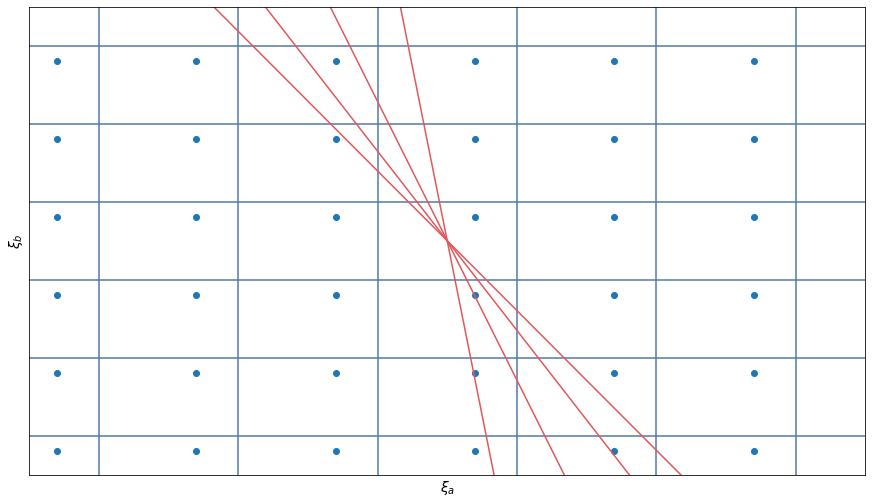

In [5]:
fig, ax = pyplot.subplots(constrained_layout=True, figsize=(12, 12))

spectrum_size = [res_a / size_a, res_b / size_b]
n_replicas = 6

ax.set_xlabel(r'$\xi_a$', fontsize=14)
ax.set_ylabel(r'$\xi_b$', fontsize=14)
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-n_replicas*spectrum_size[0]/2, n_replicas*spectrum_size[0]/2)
ax.set_ylim(-n_replicas*spectrum_size[1]/2, n_replicas*spectrum_size[1]/2)

ax.plot(np.repeat((sampling_lattice(n_replicas) + 0.5) * spectrum_size[0], 3), np.tile([-1000.0, 1000.0, np.nan], n_replicas), color='lfd:signal')
ax.plot(np.tile([-1000.0, 1000.0, np.nan], n_replicas), np.repeat((sampling_lattice(n_replicas) + 0.5) * spectrum_size[1], 3), color='lfd:signal')
ax.scatter(np.repeat((sampling_lattice(n_replicas) + 0.2) * spectrum_size[0], n_replicas),
           np.tile((sampling_lattice(n_replicas) + 0.3) * spectrum_size[1], n_replicas))

for i in range(4):
    ax.plot(xi_rp_to_a(np.array([-1000.0, 1000.0]), 0.0, z_r, z_a, z_b, z_f[i]), xi_rp_to_b(np.array([-1000.0, 1000.0]), 0.0, z_r, z_a, z_b, z_f[i]), color='lfd:retina')

Sampling the eye function...


Sampling:   0%|          | 0/243 [00:00<?, ?it/s]

Type               : zarr.core.Array
Data type          : float32
Shape              : (243, 243, 243, 243)
Chunk shape        : (1, 1, 243, 243)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 13947137604 (13.0G)
No. bytes stored   : 59304325 (56.6M)
Storage ratio      : 235.2
Chunks initialized : 59049/59049

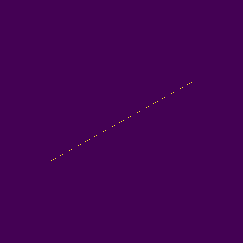

Wall time: 1min 31s


In [6]:
%%time
print('Sampling the eye function...')

eye_AABB = zarr.open('data/eye_high.zarr', mode='w', shape=(res_A, res_A, res_B, res_B), chunks=(1, 1, res_B, res_B), dtype=np.float32)

sample_eye_function(eye_AABB, res_A, res_B, size_a, size_b, z_r, z_a, z_b, z_f[3], pitch_r, pupil_diameter, block_size=1)

display(eye_AABB.info)

display_image(eye_AABB[:, 0, :, 0], shift=True)

Computing the circular importance function as the absolute value of the spectrum of the eye function...


FFT2 axes=(1, 3):   0%|          | 0/243 [00:00<?, ?it/s]

FFT2 axes=(0, 2):   0%|          | 0/243 [00:00<?, ?it/s]

Type               : zarr.core.Array
Data type          : float32
Shape              : (243, 243, 243, 243)
Chunk shape        : (1, 1, 243, 243)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 13947137604 (13.0G)
No. bytes stored   : 11845819972 (11.0G)
Storage ratio      : 1.2
Chunks initialized : 59049/59049

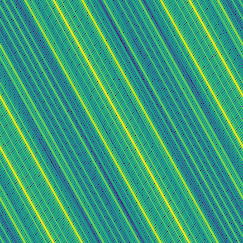

Wall time: 6min 40s


In [7]:
%%time
print('Computing the circular importance function as the absolute value of the spectrum of the eye function...')

eye_AABB = zarr.open('data/eye_high.zarr', mode='r')
weight_AABB = zarr.open('data/weight_high.zarr', mode='w', shape=(res_A, res_A, res_B, res_B), chunks=(1, 1, res_B, res_B), dtype=np.float32)

abs_fft4(eye_AABB, weight_AABB, block_size=1)

display(weight_AABB.info)

display_image(np.log(1.0 + weight_AABB[:, 0, :, 0]), shift=True)

Downsampling the eye function...


Decimating:   0%|          | 0/81 [00:00<?, ?it/s]

Type               : zarr.core.Array
Data type          : float32
Shape              : (81, 81, 81, 81)
Chunk shape        : (1, 1, 81, 81)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 172186884 (164.2M)
No. bytes stored   : 1181473 (1.1M)
Storage ratio      : 145.7
Chunks initialized : 6561/6561

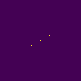

Wall time: 14.2 s


In [8]:
%%time
print('Downsampling the eye function...')

eye_AABB = zarr.open('data/eye_high.zarr', mode='r')
eye_aabb = zarr.open('data/eye_low.zarr', mode='w', shape=(res_a, res_a, res_b, res_b), chunks=(1, 1, res_b, res_b), dtype=np.float32)

decimate_signal(eye_AABB, eye_aabb, oversampling)

display(eye_aabb.info)

display_image(eye_aabb[:, 0, :, 0], shift=True)

Computing the downsampled circular importance function as the absolute value of the spectrum of the downsampled eye function...


FFT2 axes=(1, 3):   0%|          | 0/81 [00:00<?, ?it/s]

FFT2 axes=(0, 2):   0%|          | 0/81 [00:00<?, ?it/s]

Type               : zarr.core.Array
Data type          : float32
Shape              : (81, 81, 81, 81)
Chunk shape        : (1, 1, 81, 81)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 172186884 (164.2M)
No. bytes stored   : 114117395 (108.8M)
Storage ratio      : 1.5
Chunks initialized : 6561/6561

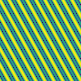

Wall time: 24.1 s


In [9]:
%%time
print('Computing the downsampled circular importance function as the absolute value of the spectrum of the downsampled eye function...')

eye_aabb = zarr.open('data/eye_low.zarr', mode='r')
weight_aabb = zarr.open('data/weight_low.zarr', mode='w', shape=(res_a, res_a, res_b, res_b), chunks=(1, 1, res_b, res_b), dtype=np.float32)

abs_fft4(eye_aabb, weight_aabb, block_size=1)

display(weight_aabb.info)

display_image(np.log(1.0 + weight_aabb[:, 0, :, 0]), shift=True)

In [10]:
if False:
    %%time
    print('Computing the normalized circular importance function...')

    weight_AABB = zarr.open('data/weight_high.zarr', mode='r')
    weight_aabb = zarr.open('data/weight_low.zarr', mode='r')
    norm_AABB = zarr.open('data/norm_high.zarr', mode='w', shape=(res_A, res_A, res_B, res_B), chunks=(1, 1, res_B, res_B), dtype=np.float32)

    for block_start in tqdm(np.arange(0, res_A, dtype=np.uint32), desc='Normalizing filter'):
        block_slice = slice(block_start, block_start + 1)
        block_slice_mod = slice(block_start % res_a, (block_start % res_a) + 1)
        norm_AABB[block_slice] = (cp.array(weight_AABB[block_slice]) * cp.tile(cp.nan_to_num(cp.reciprocal(cp.array(weight_aabb[block_slice_mod]))), (1, oversampling, oversampling, oversampling))).get()

    display(norm_AABB.info)

    display_image(np.log(1.0 + norm_AABB[:, 0, :, 0]), shift=True)

Computing the choice filter...


Computing choice:   0%|          | 0/81 [00:00<?, ?it/s]

Type               : zarr.core.Array
Data type          : bool
Shape              : (243, 243, 243, 243)
Chunk shape        : (1, 1, 243, 243)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 3486784401 (3.2G)
No. bytes stored   : 32780150 (31.3M)
Storage ratio      : 106.4
Chunks initialized : 59049/59049

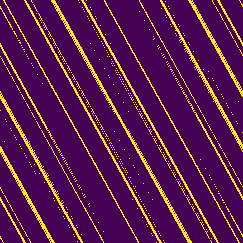

Wall time: 1min 48s


In [11]:
%%time
print('Computing the choice filter...')

weight_AABB = zarr.open('data/weight_high.zarr', mode='r')
choice_AABB = zarr.open('data/choice_high.zarr', mode='w', shape=(res_A, res_A, res_B, res_B), chunks=(1, 1, res_B, res_B), dtype=np.bool8)

compute_choice_filter(weight_AABB, choice_AABB, oversampling)

display(choice_AABB.info)

display_image(choice_AABB[:, 0, :, 0], shift=True)

Test signal...


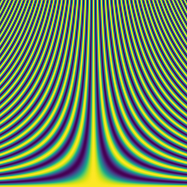

Wall time: 47.9 ms


In [12]:
%%time
print('Test signal...')

signal_function = cosine_signal
display_image(signal_function(cp.linspace(0.0, 1.0, res_r//2)[: , np.newaxis], cp.linspace(0.0, 1.0, res_r//2)[np.newaxis, :]).get())

Sampling the light field signal...


Sampling:   0%|          | 0/243 [00:00<?, ?it/s]

Type               : zarr.core.Array
Data type          : float32
Shape              : (243, 243, 243, 243)
Chunk shape        : (1, 1, 243, 243)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 13947137604 (13.0G)
No. bytes stored   : 3423205240 (3.2G)
Storage ratio      : 4.1
Chunks initialized : 59049/59049

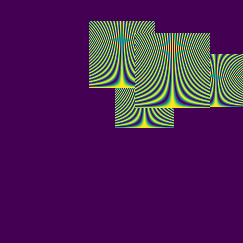

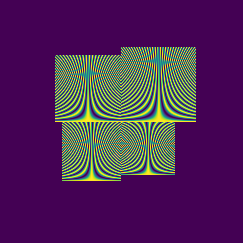

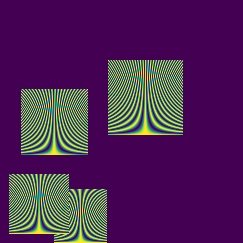

Wall time: 2min 27s


In [13]:
%%time
print('Sampling the light field signal...')

signal_AABB = zarr.open('data/signal_high.zarr', mode='w', shape=(res_A, res_A, res_B, res_B), chunks=(1, 1, res_B, res_B), dtype=np.float32)

sample_signal_quadrants(signal_AABB, signal_function, res_A, res_B, size_r, size_a, size_b, z_r, z_a, z_b, z_f, block_size=1)

display(signal_AABB.info)

display_image(signal_AABB[res_A//2+1, res_A//2+1], shift=True, flip=True)
display_image(signal_AABB[0, 0], shift=True, flip=True)
display_image(signal_AABB[res_A//2, res_A//2], shift=True, flip=True)

Downsampling the unfiltered sampled light field signal...


Decimating:   0%|          | 0/81 [00:00<?, ?it/s]

Type               : zarr.core.Array
Data type          : float32
Shape              : (81, 81, 81, 81)
Chunk shape        : (1, 1, 81, 81)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 172186884 (164.2M)
No. bytes stored   : 51046756 (48.7M)
Storage ratio      : 3.4
Chunks initialized : 6561/6561

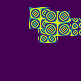

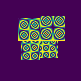

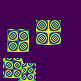

Wall time: 16.9 s


In [14]:
%%time
print('Downsampling the unfiltered sampled light field signal...')

signal_AABB = zarr.open('data/signal_high.zarr', mode='r')
signal_aabb = zarr.open('data/signal_low.zarr', mode='w', shape=(res_a, res_a, res_b, res_b), chunks=(1, 1, res_b, res_b), dtype=np.float32)

decimate_signal(signal_AABB, signal_aabb, oversampling)

display(signal_aabb.info)

display_image(signal_aabb[res_a//2+1, res_a//2+1], shift=True, flip=True)
display_image(signal_aabb[0, 0], shift=True, flip=True)
display_image(signal_aabb[res_a//2, res_a//2], shift=True, flip=True)

Computing the spectrum of the sampled light field signal...


RFFT2 axes=(1, 3):   0%|          | 0/243 [00:00<?, ?it/s]

FFT2 axes=(0, 2):   0%|          | 0/243 [00:00<?, ?it/s]

Type               : zarr.core.Array
Data type          : complex64
Shape              : (243, 243, 243, 122)
Chunk shape        : (1, 1, 243, 122)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 14004533232 (13.0G)
No. bytes stored   : 13208137051 (12.3G)
Storage ratio      : 1.1
Chunks initialized : 59049/59049

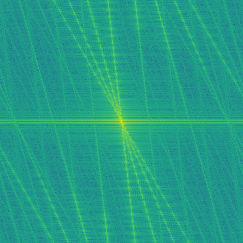

Wall time: 7min 37s


In [15]:
%%time
print('Computing the spectrum of the sampled light field signal...')

signal_AABB = zarr.open('data/signal_high.zarr', mode='r')
spectrum_AABB = zarr.open('data/spectrum_high.zarr', mode='w', shape=(res_A, res_A, res_B, res_B//2+1), chunks=(1, 1, res_B, res_B//2+1), dtype=np.complex64)

rfft4(signal_AABB, spectrum_AABB, block_size=1)

display(spectrum_AABB.info)

display_image(np.log(1.0 + np.abs(spectrum_AABB[:, 0, :, 0])), shift=True)

Filtering the spectrum with the weight filter...


Filtering:   0%|          | 0/243 [00:00<?, ?it/s]

Type               : zarr.core.Array
Data type          : complex64
Shape              : (243, 243, 243, 122)
Chunk shape        : (1, 1, 243, 122)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 14004533232 (13.0G)
No. bytes stored   : 13666613193 (12.7G)
Storage ratio      : 1.0
Chunks initialized : 59049/59049

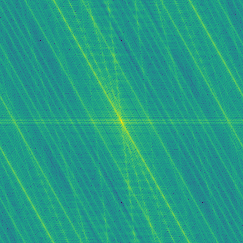

Wall time: 9min 39s


In [16]:
%%time
print('Filtering the spectrum with the weight filter...')

spectral_filter = zarr.open('data/weight_high.zarr', mode='r')
spectrum_AABB = zarr.open('data/spectrum_high.zarr', mode='r')
filtered_AABB = zarr.open('data/spectrum_high_filtered.zarr', mode='w', shape=(res_A, res_A, res_B, res_B//2+1), chunks=(1, 1, res_B, res_B//2+1), dtype=np.complex64)

filter_spectrum(spectral_filter, spectrum_AABB, filtered_AABB, block_size=1)

display(filtered_AABB.info)

display_image(np.log(1.0 + np.abs(filtered_AABB[:, 0, :, 0])), shift=True)

Computing the light field signal from the filtered spectrum...


IFFT2 axes=(0, 2):   0%|          | 0/243 [00:00<?, ?it/s]

IRFFT2 axes=(1, 3):   0%|          | 0/243 [00:00<?, ?it/s]

Type               : zarr.core.Array
Data type          : float32
Shape              : (243, 243, 243, 243)
Chunk shape        : (1, 1, 243, 243)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 13947137604 (13.0G)
No. bytes stored   : 11397162125 (10.6G)
Storage ratio      : 1.2
Chunks initialized : 59049/59049

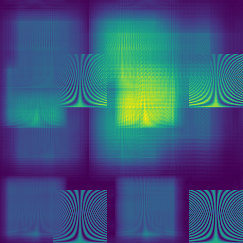

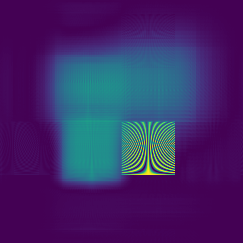

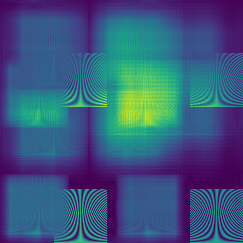

Wall time: 10min 29s


In [17]:
%%time
print('Computing the light field signal from the filtered spectrum...')

spectrum_AABB = zarr.open('data/spectrum_high_filtered.zarr', mode='r')
signal_AABB = zarr.open('data/signal_high_filtered.zarr', mode='w', shape=(res_A, res_A, res_B, res_B), chunks=(1, 1, res_B, res_B), dtype=np.float32)

irfft4(spectrum_AABB, signal_AABB, block_size=1)

display(signal_AABB.info)

display_image(signal_AABB[res_A//2+1, res_A//2+1], shift=True, flip=True)
display_image(signal_AABB[0, 0], shift=True, flip=True)
display_image(signal_AABB[res_A//2, res_A//2], shift=True, flip=True)

Downsampling the prefiltered light field signal...


Decimating:   0%|          | 0/81 [00:00<?, ?it/s]

Type               : zarr.core.Array
Data type          : float32
Shape              : (81, 81, 81, 81)
Chunk shape        : (1, 1, 81, 81)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 172186884 (164.2M)
No. bytes stored   : 147065711 (140.3M)
Storage ratio      : 1.2
Chunks initialized : 6561/6561

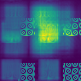

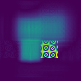

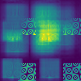

Wall time: 22.8 s


In [18]:
%%time
print('Downsampling the prefiltered light field signal...')

signal_AABB = zarr.open('data/signal_high_filtered.zarr', mode='r')
signal_aabb = zarr.open('data/signal_low_weight.zarr', mode='w', shape=(res_a, res_a, res_b, res_b), chunks=(1, 1, res_b, res_b), dtype=np.float32)

decimate_signal(signal_AABB, signal_aabb, oversampling)

display(signal_aabb.info)

display_image(signal_aabb[res_a//2+1, res_a//2+1], shift=True, flip=True)
display_image(signal_aabb[0, 0], shift=True, flip=True)
display_image(signal_aabb[res_a//2, res_a//2], shift=True, flip=True)

Filtering the spectrum with the choice filter...


Filtering:   0%|          | 0/243 [00:00<?, ?it/s]

Type               : zarr.core.Array
Data type          : complex64
Shape              : (243, 243, 243, 122)
Chunk shape        : (1, 1, 243, 122)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 14004533232 (13.0G)
No. bytes stored   : 2099805619 (2.0G)
Storage ratio      : 6.7
Chunks initialized : 59049/59049

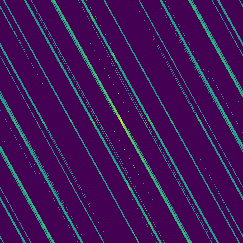

Wall time: 4min 6s


In [19]:
%%time
print('Filtering the spectrum with the choice filter...')

spectral_filter = zarr.open('data/choice_high.zarr', mode='r')
spectrum_AABB = zarr.open('data/spectrum_high.zarr', mode='r')
filtered_AABB = zarr.open('data/spectrum_high_filtered.zarr', mode='w', shape=(res_A, res_A, res_B, res_B//2+1), chunks=(1, 1, res_B, res_B//2+1), dtype=np.complex64)

filter_spectrum(spectral_filter, spectrum_AABB, filtered_AABB, block_size=1)

display(filtered_AABB.info)

display_image(np.log(1.0 + np.abs(filtered_AABB[:, 0, :, 0])), shift=True)

Computing the light field signal from the filtered spectrum...


IFFT2 axes=(0, 2):   0%|          | 0/243 [00:00<?, ?it/s]

IRFFT2 axes=(1, 3):   0%|          | 0/243 [00:00<?, ?it/s]

Type               : zarr.core.Array
Data type          : float32
Shape              : (243, 243, 243, 243)
Chunk shape        : (1, 1, 243, 243)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 13947137604 (13.0G)
No. bytes stored   : 12042255176 (11.2G)
Storage ratio      : 1.2
Chunks initialized : 59049/59049

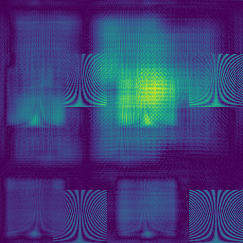

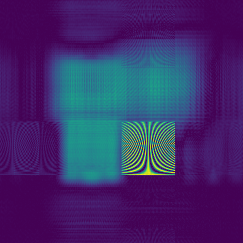

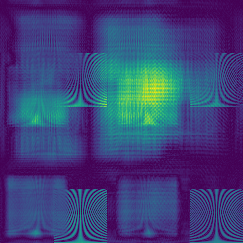

Wall time: 5min


In [20]:
%%time
print('Computing the light field signal from the filtered spectrum...')

spectrum_AABB = zarr.open('data/spectrum_high_filtered.zarr', mode='r')
signal_AABB = zarr.open('data/signal_high_filtered.zarr', mode='w', shape=(res_A, res_A, res_B, res_B), chunks=(1, 1, res_B, res_B), dtype=np.float32)

irfft4(spectrum_AABB, signal_AABB, block_size=1)

display(signal_AABB.info)

display_image(signal_AABB[res_A//2+1, res_A//2+1], shift=True, flip=True)
display_image(signal_AABB[0, 0], shift=True, flip=True)
display_image(signal_AABB[res_A//2, res_A//2], shift=True, flip=True)

Downsampling the prefiltered light field signal...


Decimating:   0%|          | 0/81 [00:00<?, ?it/s]

Type               : zarr.core.Array
Data type          : float32
Shape              : (81, 81, 81, 81)
Chunk shape        : (1, 1, 81, 81)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 172186884 (164.2M)
No. bytes stored   : 154928267 (147.8M)
Storage ratio      : 1.1
Chunks initialized : 6561/6561

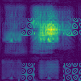

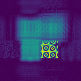

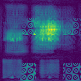

Wall time: 31.3 s


In [21]:
%%time
print('Downsampling the prefiltered light field signal...')

signal_AABB = zarr.open('data/signal_high_filtered.zarr', mode='r')
signal_aabb = zarr.open('data/signal_low_choice.zarr', mode='w', shape=(res_a, res_a, res_b, res_b), chunks=(1, 1, res_b, res_b), dtype=np.float32)

decimate_signal(signal_AABB, signal_aabb, oversampling)

display(signal_aabb.info)

display_image(signal_aabb[res_a//2+1, res_a//2+1], shift=True, flip=True)
display_image(signal_aabb[0, 0], shift=True, flip=True)
display_image(signal_aabb[res_a//2, res_a//2], shift=True, flip=True)

In [24]:
%%time
print('Setting up display signals...')

unfiltered = zarr.open('data/signal_low.zarr', mode='r')
weight = zarr.open('data/signal_low_weight.zarr', mode='r')
choice = zarr.open('data/signal_low_choice.zarr', mode='r')

signals_aabb = [unfiltered,
                weight, np.maximum(weight, 0.0),
                choice, np.maximum(choice, 0.0)]

labels = ['Unfiltered',
          'Weight', 'Weight (nonnegative)',
          'Choice', 'Choice (nonnegative)']

Setting up display signals...
Wall time: 6.76 s


Computing retinal images with focus at z_f[3] from downsampled light field signals...


For each retina sample:   0%|          | 0/140625 [00:00<?, ?it/s]

Unfiltered:


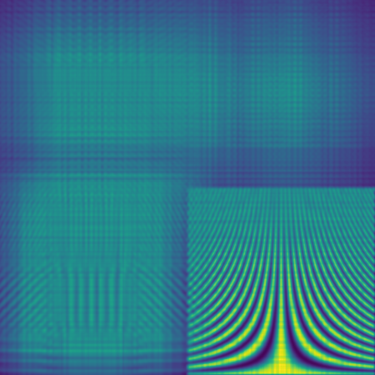

Weight:


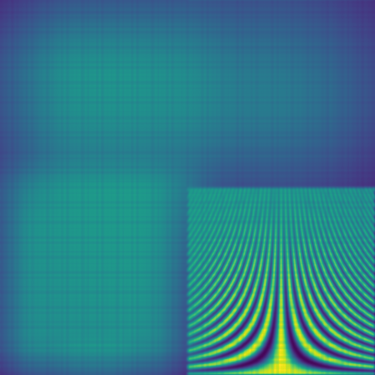

Weight (nonnegative):


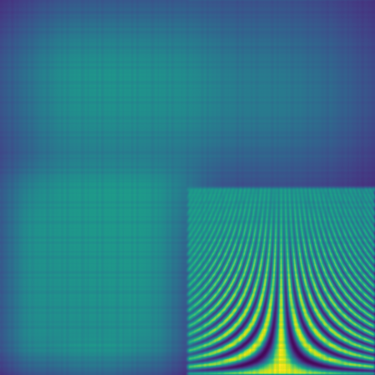

Choice:


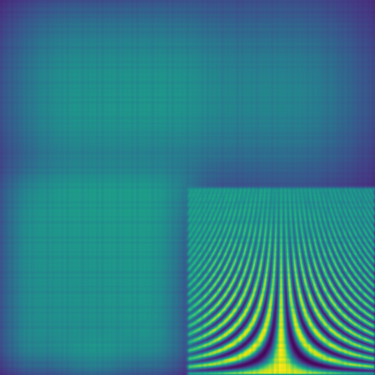

Choice (nonnegative):


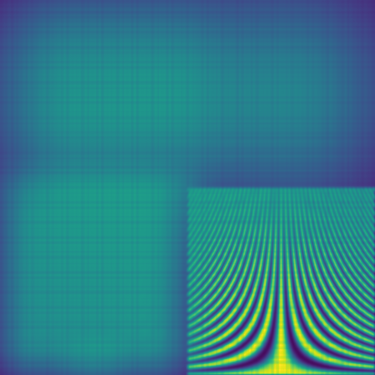

Wall time: 48min 46s


In [25]:
%%time
print('Computing retinal images with focus at z_f[3] from downsampled light field signals...')

retinal_images = compute_retinal_images(signals_aabb, res_r, res_a, res_b, size_r, size_a, size_b, z_r, z_a, z_b, z_f[3], w_a, w_b, pupil_diameter, square_aperture, block_size=81)

for i in range(len(retinal_images)):
    print(labels[i] + ':')
    display_image(retinal_images[i], shift=True)

Computing retinal images with focus at z_f[2] from downsampled light field signals...


For each retina sample:   0%|          | 0/140625 [00:00<?, ?it/s]

Unfiltered:


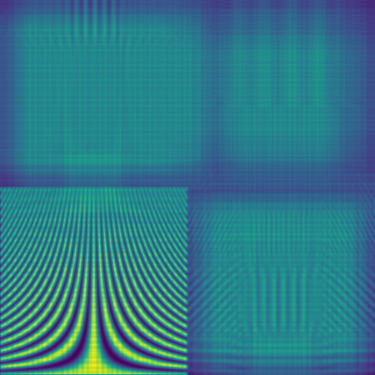

Weight:


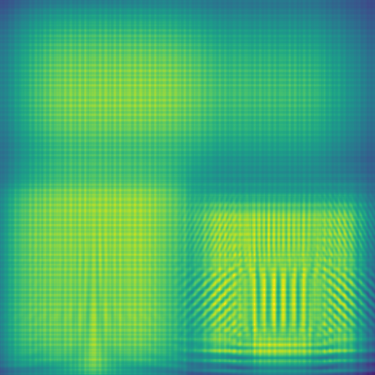

Weight (nonnegative):


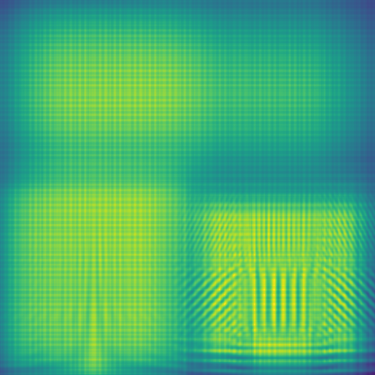

Choice:


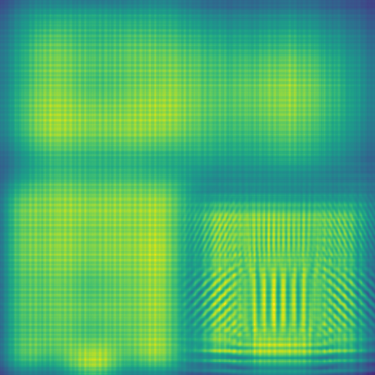

Choice (nonnegative):


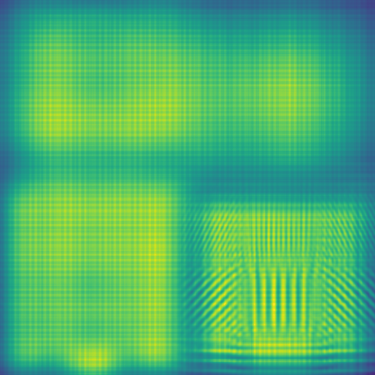

Wall time: 48min 30s


In [26]:
%%time
print('Computing retinal images with focus at z_f[2] from downsampled light field signals...')

retinal_images = compute_retinal_images(signals_aabb, res_r, res_a, res_b, size_r, size_a, size_b, z_r, z_a, z_b, z_f[2], w_a, w_b, pupil_diameter, square_aperture, block_size=81)

for i in range(len(retinal_images)):
    print(labels[i] + ':')
    display_image(retinal_images[i], shift=True)

Computing retinal images with focus at z_f[1] from downsampled light field signals...


For each retina sample:   0%|          | 0/140625 [00:00<?, ?it/s]

Unfiltered:


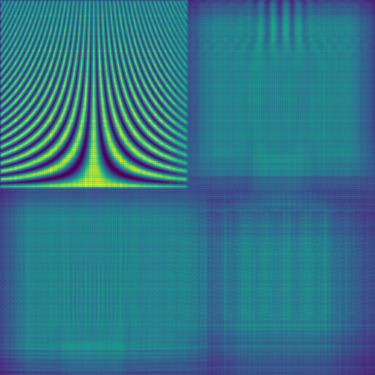

Weight:


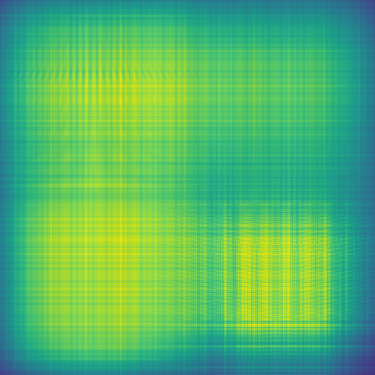

Weight (nonnegative):


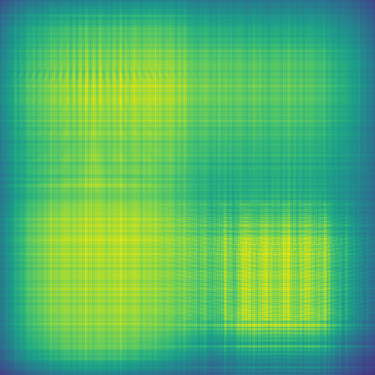

Choice:


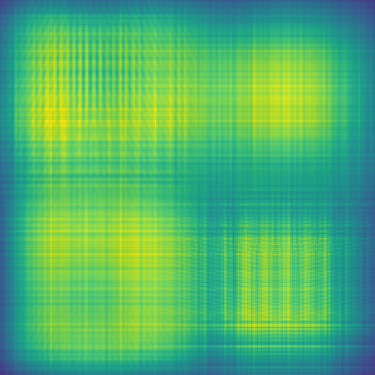

Choice (nonnegative):


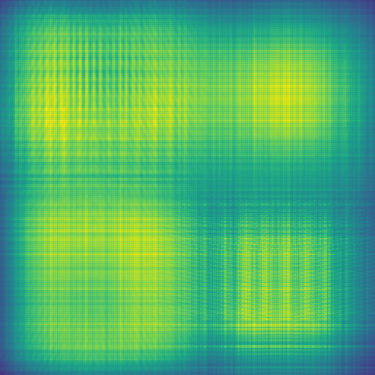

Wall time: 48min 46s


In [27]:
%%time
print('Computing retinal images with focus at z_f[1] from downsampled light field signals...')

retinal_images = compute_retinal_images(signals_aabb, res_r, res_a, res_b, size_r, size_a, size_b, z_r, z_a, z_b, z_f[1], w_a, w_b, pupil_diameter, square_aperture, block_size=81)

for i in range(len(retinal_images)):
    print(labels[i] + ':')
    display_image(retinal_images[i], shift=True)

Computing retinal images with focus at z_f[0] from downsampled light field signals...


For each retina sample:   0%|          | 0/140625 [00:00<?, ?it/s]

Unfiltered:


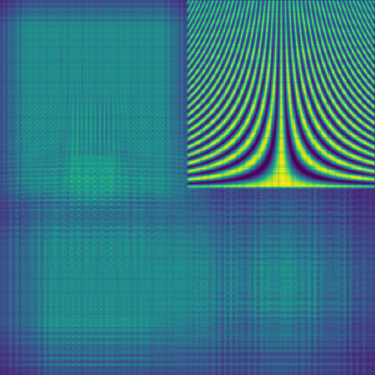

Weight:


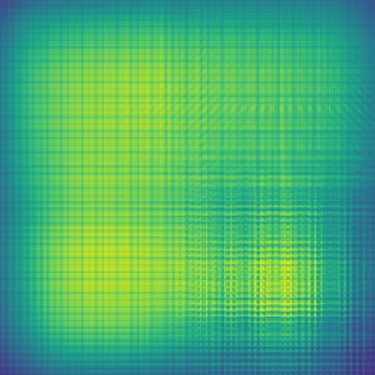

Weight (nonnegative):


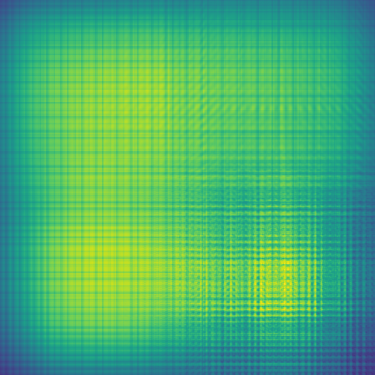

Choice:


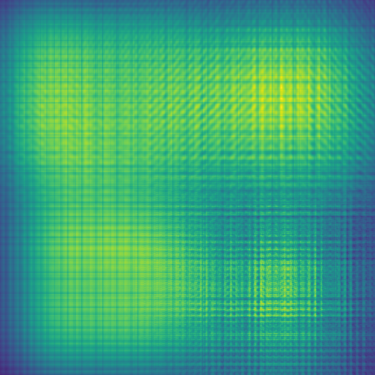

Choice (nonnegative):


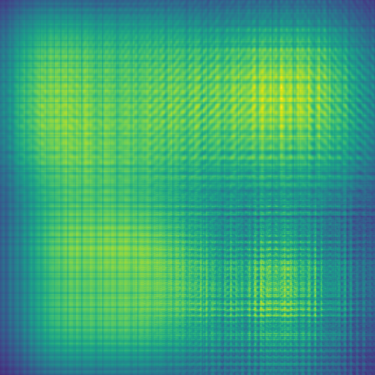

Wall time: 50min 4s


In [28]:
%%time
print('Computing retinal images with focus at z_f[0] from downsampled light field signals...')

retinal_images = compute_retinal_images(signals_aabb, res_r, res_a, res_b, size_r, size_a, size_b, z_r, z_a, z_b, z_f[0], w_a, w_b, pupil_diameter, square_aperture, block_size=81)

for i in range(len(retinal_images)):
    print(labels[i] + ':')
    display_image(retinal_images[i], shift=True)